In [1]:
%%capture
!pip install timm torchsummary tqdm grad-cam

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, EigenGradCAM, LayerCAM, FullGrad

%matplotlib inline

In [3]:
np.random.seed(42)
torch.manual_seed(42)

## Setting up the GPU/CPU
will depend on the selected runtime for colab

In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## Loading images to check

In [5]:
test_image_path_1  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/436219-7159-48057-[1, 0, 0].png'
#test_image_path_2  = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/439448-38035-50808-[0, 1, 0].png'
valid_image_path   = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00.png'
valid_mask_path    = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Viz_Test_Images/00_1.png'

In [6]:
test_image_1  = cv2.resize(cv2.imread(test_image_path_1), (224, 224))
#test_image_2  = cv2.resize(cv2.imread(test_image_path_2), (224, 224))
valid_image = cv2.resize(cv2.imread(valid_image_path), (224, 224))
valid_mask  = cv2.resize(cv2.imread(valid_mask_path), (224, 224))

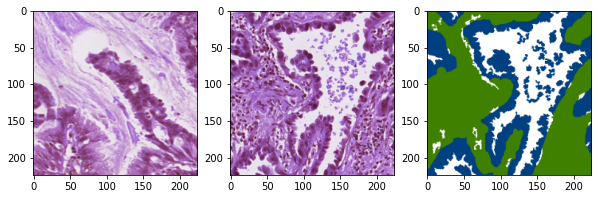

In [7]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(1, 3, 2)
plt.imshow(valid_image)

ax = fig.add_subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

In [8]:
def preprocess_image(img: np.ndarray, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], resized = (224, 224)) -> torch.Tensor:
  
  preprocessing = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Resize((224, 224)),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                      ])
  return preprocessing(img.copy()).unsqueeze(0)

In [9]:
def reshape_transform(tensor, height=14, width=14):
  result = tensor[:, 1 :  , :].reshape(tensor.size(0),
                                       height, width, tensor.size(2))
  
  # Bring the channels to the first dimension,
  # like in CNNs.
  result = result.transpose(2, 3).transpose(1, 2)
  return result

In [10]:
def show_mask_on_image(img, mask):
    img = np.float32(img) / 255
    mask = cv2.resize(mask, (224, 224))
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(img)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)

# Creating models

In [11]:
model_1 = timm.create_model('vit_base_patch16_224', pretrained = False, num_classes = 3,
                            drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_1.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_01.pth',
                                   map_location=torch.device(device)))

<All keys matched successfully>

In [12]:
model_2 = timm.create_model('vit_base_patch16_224', pretrained = False, num_classes = 3,
                            drop_rate = 0.2, attn_drop_rate = 0.2).to(device)

model_2.load_state_dict(torch.load(f='/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/border_cutmix_model_vit_base_patch16_224_02.pth',
                                   map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
model_1.eval()
model_2.eval()

In [14]:
target_layer_model_1 = [model_1.blocks[-1].norm1]
target_layer_model_1

target_layer_model_2 = [model_2.blocks[-1].norm1]
target_layer_model_2

[LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [15]:
t_ls_1 = [x.norm1 for x in model_1.blocks]
t_ls_1

t_ls_2 = [x.norm1 for x in model_2.blocks]
t_ls_2

[LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True),
 LayerNorm((768,), eps=1e-06, elementwise_affine=True)]

In [16]:
t_lls_1 = [[x.norm1] for x in model_1.blocks]
t_lls_1

t_lls_2 = [[x.norm1] for x in model_2.blocks]
t_lls_2

[[LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)],
 [LayerNorm((768,), eps=1e-06, elementwise_affine=True)]]

# Configuring images

In [17]:
test_image_1_tensor = preprocess_image(test_image_1).to(device)
#test_image_2_tensor = preprocess_image(test_image_2).to(device)
valid_image_tensor  = preprocess_image(valid_image).to(device)

# GradCAM model 1

In [18]:
cam = GradCAM(model = model_1, target_layers=target_layer_model_1,
              reshape_transform=reshape_transform)

## image 1

In [19]:
grayscale_cam1 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

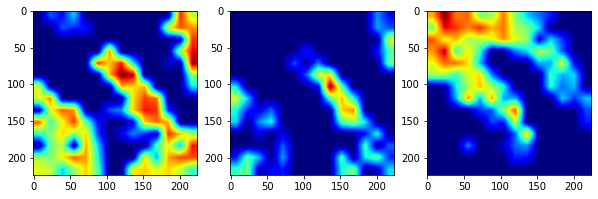

In [20]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

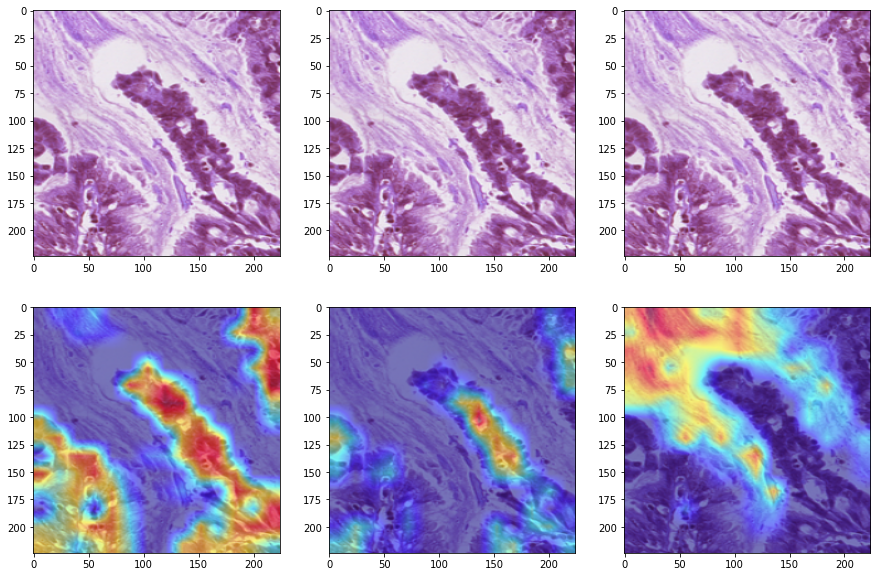

In [21]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam3[0, :], use_rgb=True))

## valid Image

In [22]:
grayscale_cam1 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

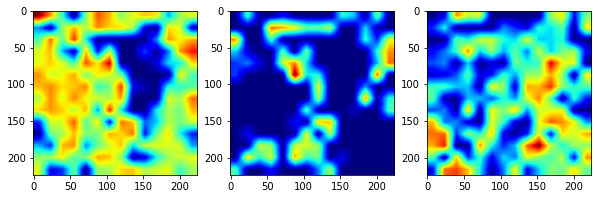

In [23]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

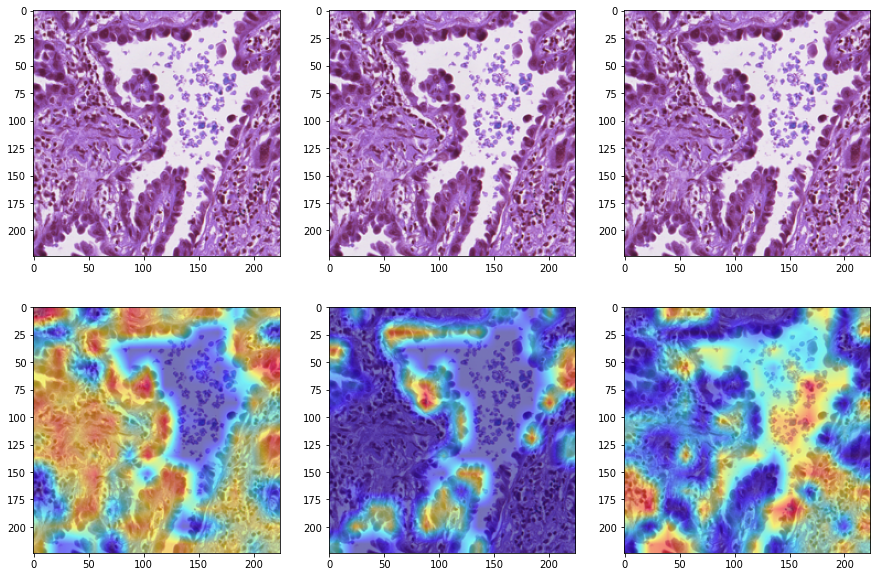

In [24]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam3[0, :], use_rgb=True))

## varied

In [25]:
grayscale_cam1 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [26]:
cams_0 = GradCAM(model = model_1, target_layers=t_ls_1, reshape_transform=reshape_transform)

In [27]:
cams = [GradCAM(model = model_1, target_layers=x, reshape_transform=reshape_transform) for x in t_lls_1]

In [28]:
test_cams = [x(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

In [29]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [30]:
test_cam_max = np.vstack(test_cams).max(axis=0)

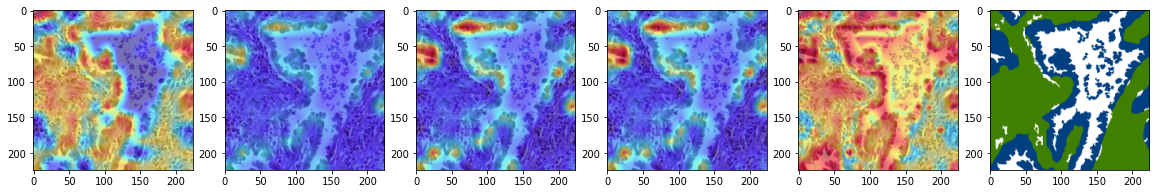

In [31]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam1[0, :], use_rgb=True))     # from just the last block

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_image/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_image/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_image/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_image/255, test_cam_max, use_rgb=True))     # max of all cams

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# GradCAM model 2

In [32]:
cam = GradCAM(model = model_2, target_layers=target_layer_model_2,
              reshape_transform=reshape_transform)

## image 1

In [33]:
grayscale_cam1 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

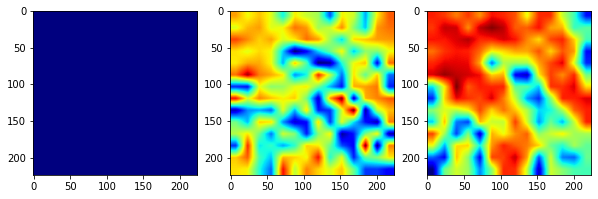

In [34]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

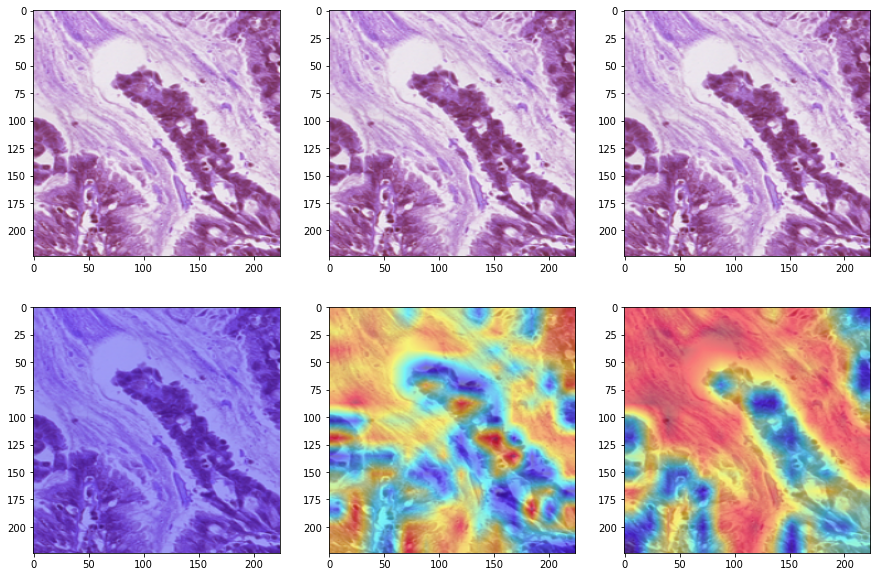

In [35]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam3[0, :], use_rgb=True))

## valid Image

In [36]:
grayscale_cam1 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

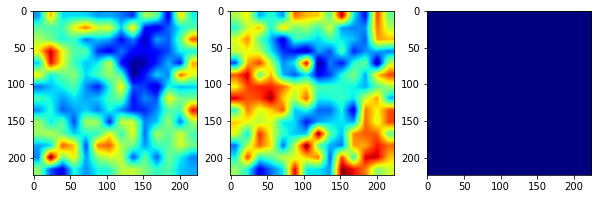

In [37]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

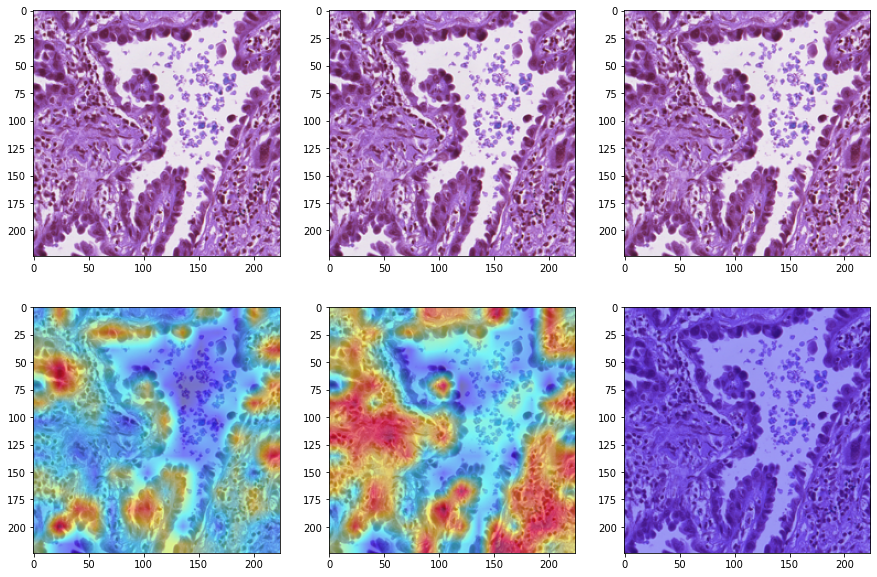

In [38]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam3[0, :], use_rgb=True))

## varied

In [39]:
grayscale_cam1 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

In [44]:
cams_0 = GradCAM(model = model_2, target_layers=t_ls_2, reshape_transform=reshape_transform)

In [45]:
cams = [GradCAM(model = model_2, target_layers=x, reshape_transform=reshape_transform) for x in t_lls_2]

In [46]:
test_cams = [x(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))]) for x in cams]
test_cams_0 = cams_0(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])

In [47]:
test_cam_mean = np.mean(np.array(test_cams), axis = 0)
test_cam_sum = np.array(test_cams).sum(axis=0)

In [48]:
test_cam_max = np.vstack(test_cams).max(axis=0)

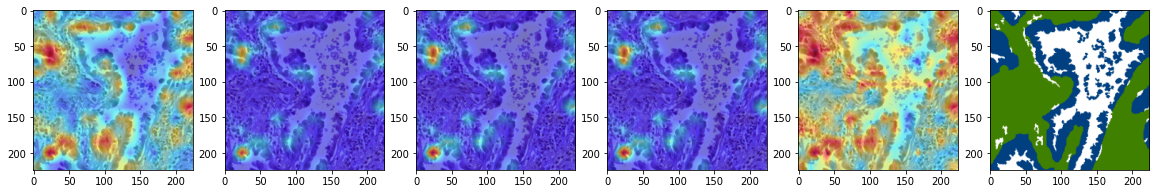

In [49]:
fig = plt.figure(figsize=(20, 20))

ax = fig.add_subplot(2, 6, 1)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam1[0, :], use_rgb=True))     # from just the last block

ax = fig.add_subplot(2, 6, 2)
plt.imshow(show_cam_on_image(valid_image/255, test_cam_mean[0, :], use_rgb=True))   # mean of the cams from all blocks

ax = fig.add_subplot(2, 6, 3)
plt.imshow(show_cam_on_image(valid_image/255, ((test_cam_sum - np.min(test_cam_sum))/np.ptp(test_cam_sum))[0, :], use_rgb=True)) # Normalized sum of all cams

ax = fig.add_subplot(2, 6, 4)
plt.imshow(show_cam_on_image(valid_image/255, test_cams_0[0, :], use_rgb=True))     # passing the whole list of layers

ax = fig.add_subplot(2, 6, 5)
plt.imshow(show_cam_on_image(valid_image/255, test_cam_max, use_rgb=True))     # max of all cams

ax = fig.add_subplot(2, 6, 6)
plt.imshow(cv2.cvtColor(valid_mask, cv2.COLOR_BGR2RGB))

# GradCAM++

In [ ]:
cam = GradCAMPlusPlus(model = cutmix_model_vit_base_patch16_224_01, target_layers=target_layer,
                      reshape_transform=reshape_transform)

## image 1

In [ ]:
grayscale_cam1 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=test_image_1_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

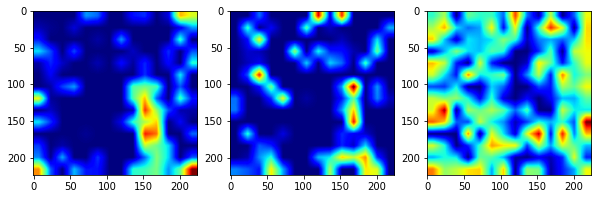

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

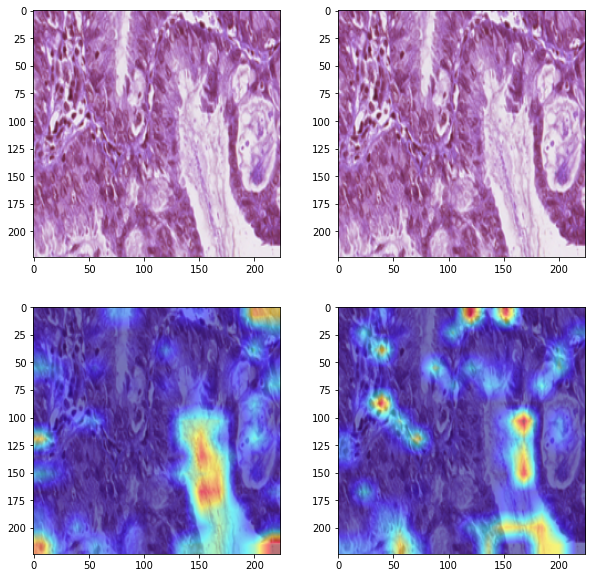

In [ ]:
fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(2, 2, 1)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 2, 2)
plt.imshow(test_image_1)

ax = fig.add_subplot(2, 2, 3)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 2, 4)
plt.imshow(show_cam_on_image(test_image_1/255, grayscale_cam2[0, :], use_rgb=True))

## image 2

In [ ]:
grayscale_cam1 = cam(input_tensor=test_image_2_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=test_image_2_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=test_image_2_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

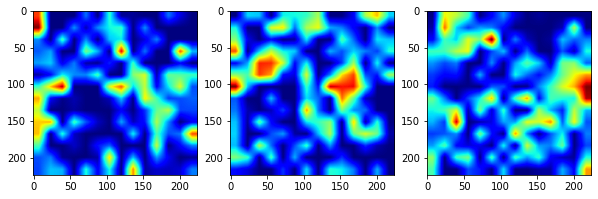

In [ ]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

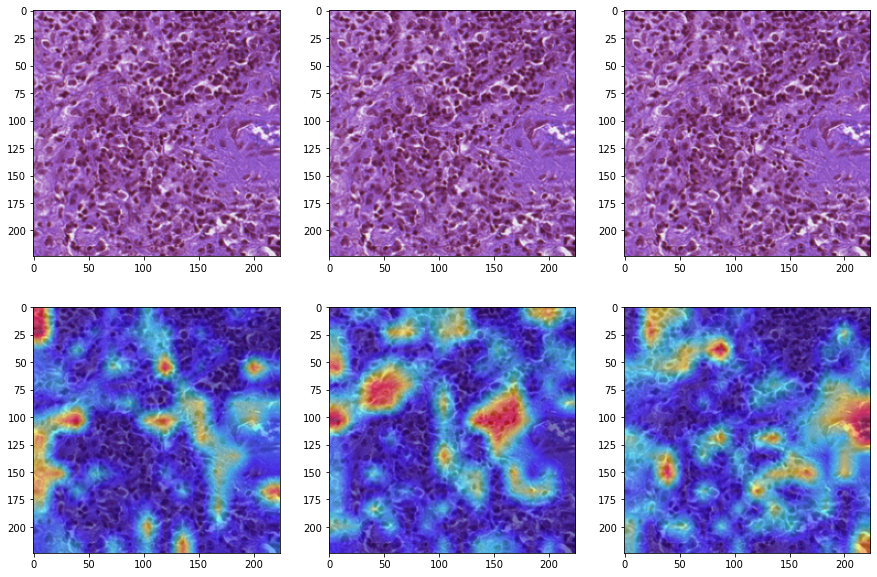

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(test_image_2)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(test_image_2)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(test_image_2)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(test_image_2/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(test_image_2/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(test_image_2/255, grayscale_cam3[0, :], use_rgb=True))

## valid Image

In [ ]:
grayscale_cam1 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([0]))])
grayscale_cam2 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([1]))])
grayscale_cam3 = cam(input_tensor=valid_image_tensor, targets=[ClassifierOutputTarget(np.array([2]))])

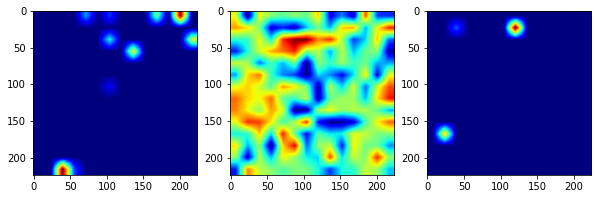

In [ ]:
fig = plt.figure(figsize=(10, 15))

ax = fig.add_subplot(1, 3, 1)
plt.imshow(grayscale_cam1[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 2)
plt.imshow(grayscale_cam2[0, :], cmap='jet')

ax = fig.add_subplot(1, 3, 3)
plt.imshow(grayscale_cam3[0, :], cmap='jet')

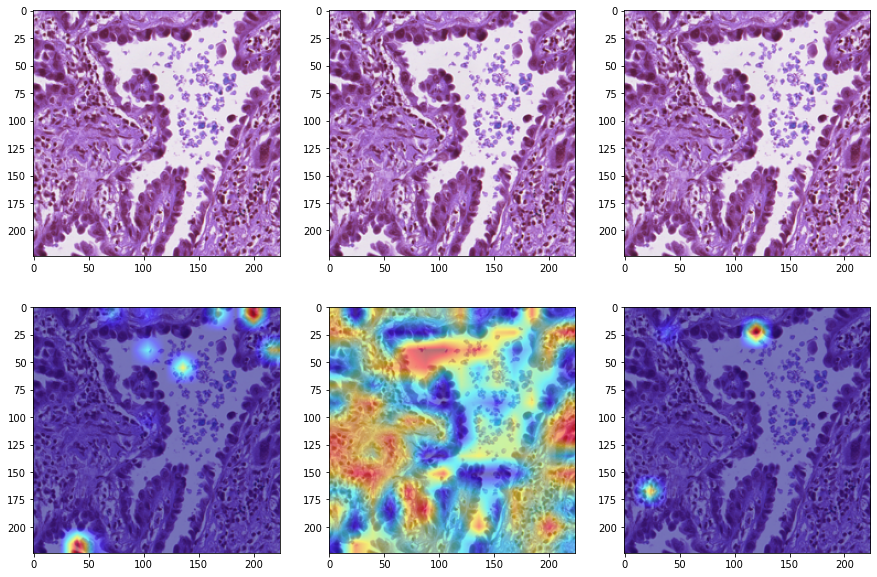

In [ ]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 3, 1)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 2)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 3)
plt.imshow(valid_image)

ax = fig.add_subplot(2, 3, 4)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam1[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 5)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam2[0, :], use_rgb=True))

ax = fig.add_subplot(2, 3, 6)
plt.imshow(show_cam_on_image(valid_image/255, grayscale_cam3[0, :], use_rgb=True))